In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import math
import torch
from torch.utils import model_zoo
import os
import pickle
import matplotlib.pyplot as plt
from utilities import sampling, one_hot_encoding, curtail, get_training_data, load_data, data_split, dianostic_plots, pad_for_detector
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [3]:
data_x = pickle.load(open('../../../../temp/buffers/ss_samples/train_x.data', 'rb'))
data_y = pickle.load(open('../../../../temp/buffers/ss_samples/train_y.data', 'rb'))
train_x, train_y, val_x, val_y = data_split(data_x, data_y, seed = 157)
train_x, val_x = pad_for_detector(train_x, 10), pad_for_detector(val_x, 10)

5016 (4013, 1000, 4) (4013,) (1003, 1000, 4) (1003,)


In [4]:
train_x, val_x = torch.from_numpy(train_x).float(), torch.from_numpy(val_x).float()
train_y, val_y = torch.from_numpy(train_y).float(), torch.from_numpy(val_y).float()

# Convert data format from channel_last to channer_first
N, L, C = train_x.shape
n, l, _ = val_x.shape
train_x = train_x.reshape(N, C, L)
val_x = val_x.reshape(n, C, l)

# Generate dataset for data loader
train_dataset = data.TensorDataset(train_x, train_y)
val_dataset = data.TensorDataset(val_x, val_y)

In [43]:
class HybridNet(nn.Module):
    
    def __init__(self, pesudo_input, num_filters, filter_size, rnn_size, fc_out, dp1, dp2, 
                 num_rnn_layers=1, rnn_dropout=0):
        super(HybridNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=num_filters, kernel_size=filter_size)
        out = self.conv1(pesudo_input)
        out = nn.MaxPool1d(kernel_size=5, stride=5)(out)
        bs, seq_len, input_size = out.shape
        out = out.reshape(seq_len, bs, input_size)
        self.bi_lstm = nn.LSTM(input_size=input_size, hidden_size=rnn_size, num_layers=num_rnn_layers,
                              batch_first=True, dropout=rnn_dropout, bidirectional=True)
        out, _ = self.bi_lstm(out)
        #print(out.shape)
        seq_len, bs, output_size = out.shape
        out = out.reshape(bs, seq_len*output_size)
        self.fc1 = nn.Linear(seq_len*output_size, fc_out)
        self.fc2 = nn.Linear(fc_out, 1)
        self.p1 = dp1
        self.p2 = dp2
        
    def forward(self, seq):
        self.activation_seq = F.relu(self.conv1(seq))
        out = nn.MaxPool1d(kernel_size=5, stride=5)(self.activation_seq)
        out = nn.Dropout(p=self.p1)(out)
        
        #################################################################################
        # Input of LSTM layer should have shape (sequence length, batch size, input_size)
        #     - Sequence length here should be the length of activation after downsampling
        #     - Input size should be the number of filters
        #################################################################################
        bs, seq_len, input_size = out.shape
        #print('shape before lstm {}'.format(out.shape))
        out = out.reshape(seq_len, bs, input_size)
        #print('shape after reshapping before lstm {}'.format(out.shape))
        out, _ = self.bi_lstm(out)
        out = F.relu(out)
        
        #################################################################################
        # Need to flatten the sequence before feeding them into fully connected layer
        #################################################################################
        seq_len, bs, output_size = out.shape
        #print('shape after lstm {}'.format(out.shape))
        out = out.reshape(bs, seq_len*output_size)
        #print('shape after reshaping {}'.format(out.shape))
        out = nn.Dropout(p=self.p2)(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = torch.squeeze(out)
        return nn.Sigmoid()(out)

In [44]:
batch_size = 256
pesudo_input = torch.rand(batch_size, C, L, dtype=train_x.dtype)
hybrid_net = HybridNet(pesudo_input,
                       num_filters=15, 
                       filter_size=10, 
                       rnn_size=10, 
                       fc_out=20, 
                       dp1=0.6, dp2=0.7).to(device)

In [45]:
optimizers = {'adam': torch.optim.Adam(hybrid_net.parameters(), lr=1e-3),
              'rmsprop': torch.optim.RMSprop(hybrid_net.parameters(), lr=1e-3)}
config = {'epochs':500, 'device':device, 
          'opt': optimizers['rmsprop'],
          'criterion':nn.BCELoss(),
          'batch_size': batch_size,
          'log_interval':10}
C, L = train_x[0].shape

In [46]:
def train(model, train_dataset, val_dataset, config):
    # Unpack config
    epochs = config['epochs']
    device = config['device']
    optimizer = config['opt']
    criterion = config['criterion']
    log_interval = config['log_interval']
    batch_size = config['batch_size']
    
    # Generate data loaders
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
    total_train_steps = len(train_loader)
    total_val_steps = len(val_loader)
    
    train_loss_list, val_loss_list = [], []
    print("Train on {} samples, validate on {} samples".format(len(train_dataset), len(val_dataset)))
    # Start training
    for epoch in range(1, epochs+1):
        train_loss_sum = 0
        model.train()
        for i, (batch, labels) in enumerate(train_loader):
            # Transfer data to GPU
            batch, labels = batch.to(device), labels.to(device)
            
            # Forward pass and calculating loss
            y_hat = model(batch)
            loss = criterion(y_hat, labels)
            
            # Backward pass and updating weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
        avg_train_loss = train_loss_sum/total_train_steps
        train_loss_list.append(avg_train_loss)
        print('epoch {}: training loss {}'.format(epoch, avg_train_loss))
        
        # Validation
        if epoch % log_interval == 0 or epoch == epochs:
            model.eval()
            val_loss_sum = 0
            for j, (batch, labels) in enumerate(train_loader):
                batch, labels = batch.to(device), labels.to(device)
                y_hat = model(batch)
                loss = criterion(y_hat, labels)
                val_loss_sum += loss.item()
            avg_val_loss = val_loss_sum/total_val_steps
            val_loss_list.append(avg_val_loss)
            print('         validation loss {}'.format(avg_val_loss))
    return model, train_loss_list, val_loss_list

In [47]:
hybrid_net, train_loss_list, val_loss_list = train(hybrid_net, train_dataset, val_dataset, config)

Train on 4013 samples, validate on 1003 samples
epoch 1: training loss 0.6962136439979076
epoch 2: training loss 0.693272277712822
epoch 3: training loss 0.6930092461407185
epoch 4: training loss 0.6922078356146812
epoch 5: training loss 0.6921547167003155
epoch 6: training loss 0.6911147907376289
epoch 7: training loss 0.6914569586515427
epoch 8: training loss 0.6905218809843063
epoch 9: training loss 0.6887050680816174
epoch 10: training loss 0.6863841749727726
         validation loss 2.7358535528182983
epoch 11: training loss 0.6837071403861046
epoch 12: training loss 0.6782642006874084
epoch 13: training loss 0.6732380874454975
epoch 14: training loss 0.671353455632925
epoch 15: training loss 0.6701143197715282
epoch 16: training loss 0.6700129099190235
epoch 17: training loss 0.6685773096978664
epoch 18: training loss 0.6709731034934521
epoch 19: training loss 0.6668900549411774
epoch 20: training loss 0.666875284165144
         validation loss 2.6563172191381454
epoch 21: traini

epoch 173: training loss 0.5459746550768614
epoch 174: training loss 0.5551831535995007
epoch 175: training loss 0.569910803809762
epoch 176: training loss 0.5376032777130604
epoch 177: training loss 0.5399888232350349
epoch 178: training loss 0.5473485570400953
epoch 179: training loss 0.5459021590650082
epoch 180: training loss 0.5300338175147772
         validation loss 2.041176915168762
epoch 181: training loss 0.5076520405709743
epoch 182: training loss 0.5537274051457644
epoch 183: training loss 0.5309009980410337
epoch 184: training loss 0.5562392212450504
epoch 185: training loss 0.5472790040075779
epoch 186: training loss 0.5175805520266294
epoch 187: training loss 0.5280074831098318
epoch 188: training loss 0.5517824925482273
epoch 189: training loss 0.5322903599590063
epoch 190: training loss 0.5161766298115253
         validation loss 2.216507211327553
epoch 191: training loss 0.5483979173004627
epoch 192: training loss 0.5253530442714691
epoch 193: training loss 0.50626052

epoch 342: training loss 0.32066711969673634
epoch 343: training loss 0.3085677521303296
epoch 344: training loss 0.34040760714560747
epoch 345: training loss 0.3109470745548606
epoch 346: training loss 0.29064752627164125
epoch 347: training loss 0.3134135459549725
epoch 348: training loss 0.33256098721176386
epoch 349: training loss 0.29634900530800223
epoch 350: training loss 0.28936813585460186
         validation loss 1.3580795414745808
epoch 351: training loss 0.3211679570376873
epoch 352: training loss 0.31361386831849813
epoch 353: training loss 0.29275777423754334
epoch 354: training loss 0.3072345210239291
epoch 355: training loss 0.3491333117708564
epoch 356: training loss 0.3199140029028058
epoch 357: training loss 0.28436176758259535
epoch 358: training loss 0.3135774889960885
epoch 359: training loss 0.314742480404675
epoch 360: training loss 0.32841918896883726
         validation loss 1.444737408310175
epoch 361: training loss 0.32133934553712606
epoch 362: training los

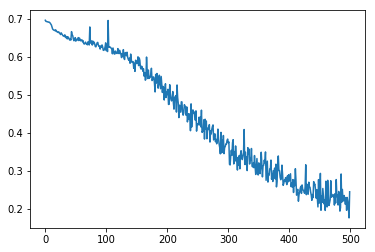

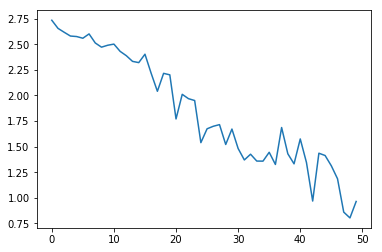

In [48]:
plt.plot(train_loss_list)
plt.show()
plt.plot(val_loss_list)
plt.show()